In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset_builder, load_dataset
from transformers import AutoProcessor, CLIPVisionModel, AutoTokenizer, CLIPTextModel
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import sys
from itertools import islice


# Loading the ROCO dataset
ds_builder = load_dataset_builder("gaodrew/roco-65k-256px")
dataset = load_dataset("gaodrew/roco-65k-256px")
train_dataset = dataset['train']


# the first 100 elements
size_of_subset = 100
candidate_training_set = train_dataset[:size_of_subset]


class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        # encoders
        self.processor_vision = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

    def __len__(self):
        return size_of_subset

    def __getitem__(self, idx):
        image = self.dataset['image'][idx]
        text = self.dataset['text'][idx]

        # Convert image from PIL to Tensor if a transform is specified
        if self.transform:
            image = self.transform(image)

        return text[:50], image


# Custom transform to replicate grayscale images to 3 channels
class ReplicateGrayscale(object):
    def __call__(self, image):
        if image.mode == 'L':
            # Replicate the single channel to have 3 channels
            image = image.convert('RGB')
        return image

# transformation pipeline
common_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# custom transform only to grayscale images
transform = transforms.Compose([
    ReplicateGrayscale(),
    common_transform
])

# custom dataset
custom_dataset = CustomDataset(candidate_training_set, transform)

# data loader
batch_size = 5
data_loader = DataLoader(custom_dataset, batch_size=batch_size)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel, AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoProcessor, CLIPVisionModel, AutoTokenizer, CLIPTextModel
import torch
import torch.nn.functional as F


# model architecture with a shared encoder for text and image
class MyContrastiveModel(nn.Module):
    def __init__(self):
        super(MyContrastiveModel, self).__init__()
        self.text_encoder = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        self.text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
        self.image_encoder = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.image_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
        self.text_project = nn.Linear(512, 768)
        self.image_project = nn.Linear(768, 768)

    def forward(self, text_input, image_input):
        text_embedding = self.text_encoder(text_input, padding=True, return_tensors="pt")
        text_embedding = self.text_model(**text_embedding)
        text_embedding = self.text_project(text_embedding.last_hidden_state[:,0,:])
        image_embedding = self.image_encoder(images=image_input, return_tensors="pt")
        image_embedding = self.image_model(**image_embedding)
        image_embedding = self.image_project(image_embedding.last_hidden_state[:,0,:])

        return text_embedding, image_embedding

# Contrastive loss function
# class ContrastiveLoss(nn.Module):
#     def __init__(self, margin=1.0):
#         super(ContrastiveLoss, self).__init__()
#         self.margin = margin

#     def forward(self, text_embedding, image_embedding, labels):
#         # labels: 1 for positive pairs, -1 for negative pairs
#         distance = nn.functional.cosine_similarity(text_embedding, image_embedding)
#         loss = 0.5 * (1 - labels) * distance.pow(2) + 0.5 * labels * torch.clamp(self.margin - distance, min=0).pow(2)
#         return loss.mean()


def contrastive_loss(text_logits, image_logits, margin=1.0):
    positive_pairs = [(image_logits[i], text_logits[i]) for i in range(len(image_logits))]

    positive_losses = [F.cosine_embedding_loss(image, text, target=torch.tensor(1.0), margin=margin) for image, text in positive_pairs]

    negative_pairs = []
    for i in range(len(image_logits)):
        for j in range(len(text_logits)):
            if i != j:
                negative_pairs.append((image_logits[i], text_logits[j]))

    negative_losses = [F.cosine_embedding_loss(image, text, target=torch.tensor(-1.0), margin=margin) for image, text in negative_pairs]

    loss = torch.mean(torch.stack(positive_losses + negative_losses))
    return loss

# Function for training with simultaneous update
def train_simultaneously(model, train_loader, criterion, optimizer, num_epochs=3):
    # loss values for plotting
    losses = []
    average_epoch_loss = 0.0

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0  # loss for the current epoch

        for text_input, image_input in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_epoch_loss:.4f}", unit="batch"):
            text_embedding, image_embedding = model(text_input, image_input)
            loss = criterion(text_embedding, image_embedding)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Calculate and store the average loss for the epoch
            average_epoch_loss = epoch_loss / len(data_loader)
            losses.append(average_epoch_loss)

    return model, losses

# Function for training with frozen image encoder
def train_with_frozen_encoder(model, train_loader, criterion, optimizer, num_epochs=3):
    # loss values for plotting
    losses = []
    average_epoch_loss = 0.0

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0  # loss for the current epoch

        for text_input, image_input in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_epoch_loss:.4f}", unit="batch"):     # Freeze the image encoder during training
            with torch.no_grad():
                image_embedding = model.image_encoder(images=image_input, return_tensors="pt")
                image_embedding = model.image_model(**image_embedding)
                image_embedding = model.image_project(image_embedding.last_hidden_state[:,0,:])
            text_embedding = model.text_encoder(text_input, padding=True, return_tensors="pt")
            text_embedding = model.text_model(**text_embedding)
            text_embedding = model.text_project(text_embedding.last_hidden_state[:,0,:])

            loss = criterion(text_embedding, image_embedding)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Calculate and store the average loss for the epoch
            average_epoch_loss = epoch_loss / len(data_loader)
            losses.append(average_epoch_loss)
    return model, losses

# Create an instance of the model and contrastive loss
model = MyContrastiveModel()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# Train with frozen image encoder
trained_model, losses = train_with_frozen_encoder(model, data_loader, contrastive_loss, optimizer, num_epochs=3)

Epoch 3/3, Average Loss: 0.0026: 100%|██████████| 20/20 [00:34<00:00,  1.75s/batch]


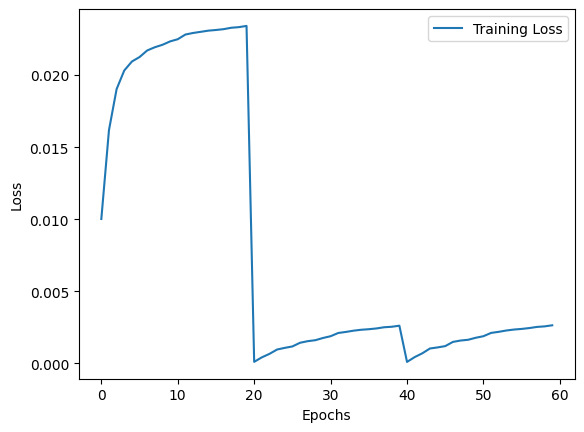

In [22]:
import matplotlib.pyplot as plt

# Plot the training loss over epochs
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_loss_plot_freezed.png')

# Save the trained model with frozen layers
torch.save(model.state_dict(), 'image_text_contrastive_training_freezed_image_encoder.pth')

In [4]:
# Train the model
trained_model, losses = trained_model_with, losses = train_simultaneously(model, data_loader, contrastive_loss, optimizer, num_epochs=3)

Epoch 3/3, Average Loss: 0.0001: 100%|██████████| 20/20 [01:18<00:00,  3.95s/batch]


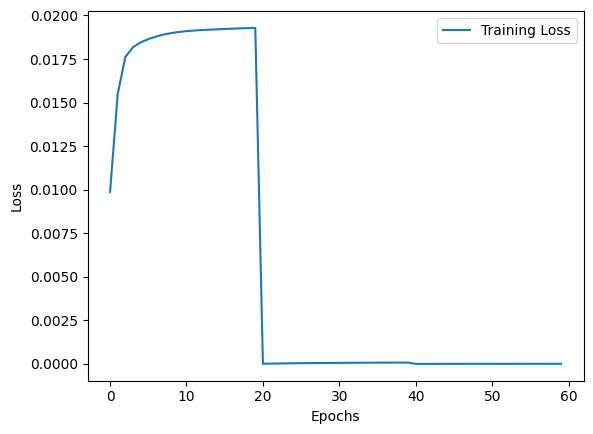

In [5]:
import matplotlib.pyplot as plt

# Plot the training loss over epochs
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_loss_plot.png')

# Save the trained model without freezing
torch.save(model.state_dict(), 'image_text_contrastive_training.pth')